In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics as st

%matplotlib inline

#import the data. (source:Kaggle)
df = pd.read_csv('diamonds.csv')

#drop 'unnamed: 0' column as it is a redundant index column
df = df.drop(['Unnamed: 0'], axis=1)

df = df[df['x'] != 0]
df = df[df['y'] != 0]
df = df[df['z'] != 0]

#optional: combine size measurements to a single feature
#df['size'] = df['x'] * df['y'] * df['z']
#df = df.drop(['x' , 'y', 'z'], axis=1)
#delete row with size of 0

#optional: renaming some column names to make them more clear (x = length of the diamond etc.)
df = df.rename(columns={'depth':'depth percentage', 'x':'length', 'y':'width', 'z':'depth'})

#optional: density parameter
#df['density'] = (df['carat'] * 200) / df['size']
#df = df.drop(['size'], axis=1)

#show the first 5 rows of the dataset
df.head()

,carat,cut,color,clarity,depth percentage,table,price,length,width,depth
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


shape of dataset (rows/columns)
(53920, 10)

number of missing values
carat               0
cut                 0
color               0
clarity             0
depth percentage    0
table               0
price               0
length              0
width               0
depth               0
dtype: int64

              carat  depth percentage         table         price  \
count  53920.000000      53920.000000  53920.000000  53920.000000   
mean       0.797698         61.749514     57.456834   3930.993231   
std        0.473795          1.432331      2.234064   3987.280446   
min        0.200000         43.000000     43.000000    326.000000   
25%        0.400000         61.000000     56.000000    949.000000   
50%        0.700000         61.800000     57.000000   2401.000000   
75%        1.040000         62.500000     59.000000   5323.250000   
max        5.010000         79.000000     95.000000  18823.000000   

             length         width         depth  
count  53920.000000  539

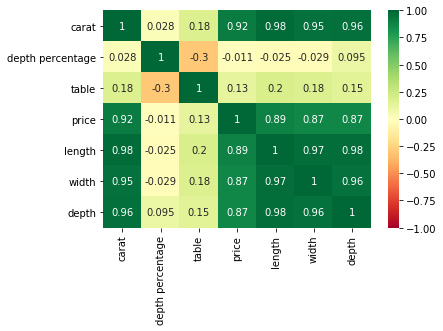

In [203]:
import seaborn as sns

#basic descriptive stats

#shape of the dataset - (rows, columns)
print('shape of dataset (rows/columns)\n', df.shape, sep="", end='\n' * 2)

#show the amount of missing values per column
print('number of missing values\n', df.isnull().sum(), sep="", end='\n' * 2)

print(df.describe(), end='\n' * 2)

#create a heatmap with the correlations matrix of the numerical features
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.show()

In [204]:
def distribution_graph(data, bins, xlabel):
    '''plots the distribution of data for a given vector
    
    input:  data: the vector (column of a df) to be plotted
            bins: the amount of bins (bars) over which the data will be distributed
            xlabel: the string label for the x-axis
    output: plot of the distribution for the given vector/column'''

    plt.hist(df[data], bins=bins, color = "black")
    plt.xlabel(xlabel)
    plt.ylabel('Number of observations')
    plt.show()

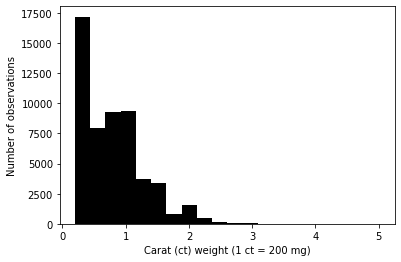

In [205]:
distribution_graph('carat', 20, 'Carat (ct) weight (1 ct = 200 mg)')

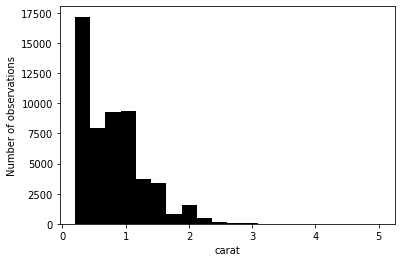

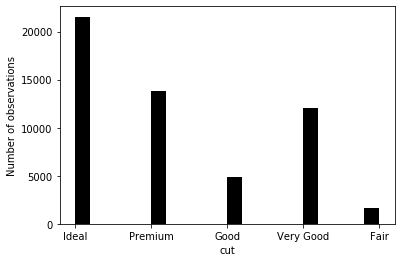

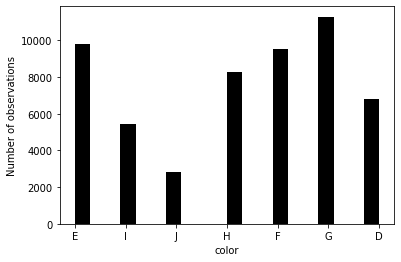

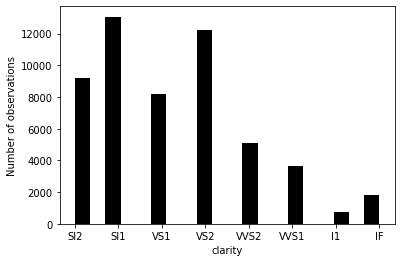

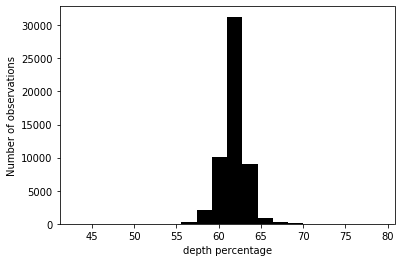

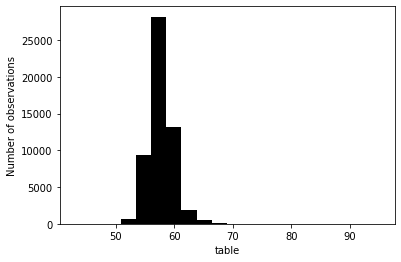

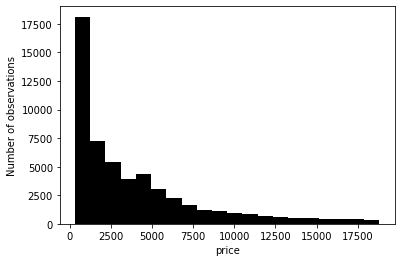

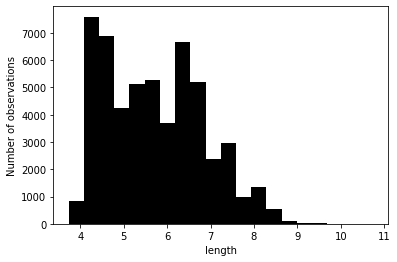

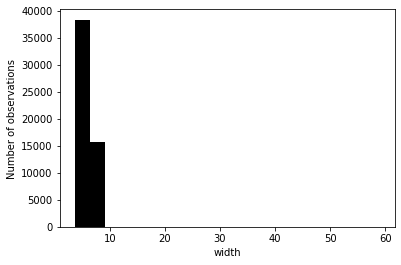

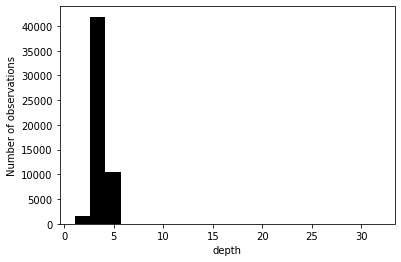

In [206]:
column_list = list(df.columns)
for f in column_list:
    distribution_graph(f, 20, f)

In [207]:
#create the matrix X with the model features and y vector with the dependant variable 'price'
X = df.drop('price', axis=1)
y = df['price']

#normalize numerical features (x - mean) / st dev
num_cols = X.select_dtypes(['number']).columns
num_col_mean = {}
num_col_stdev = {}

for col in num_cols:
    num_col_mean[col] = X[col].mean()
    num_col_stdev[col] = st.stdev(X[col])
    X[col] = (X[col] - num_col_mean[col]) / num_col_stdev[col]

#create dummy variables for categorical features
cat_cols = X.select_dtypes(['object']).columns

for col in cat_cols:
    X = pd.concat([X.drop(col, axis=1), pd.get_dummies(X[col], prefix=col, prefix_sep="_")], axis = 1)

X.head()

,carat,depth percentage,table,length,width,depth,cut_Fair,cut_Good,cut_Ideal,cut_Premium,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,-1.198193,-0.174201,-1.099715,-1.591558,-1.539205,-1.580069,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,-1.240405,-1.361078,1.585973,-1.645157,-1.661998,-1.750880,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,-1.198193,-3.385749,3.376432,-1.502227,-1.460266,-1.750880,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,-1.071556,0.454145,0.243129,-1.368229,-1.319931,-1.295384,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
4,-1.029344,1.082491,0.243129,-1.243165,-1.214679,-1.124573,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0


In [208]:
'''
set a baseline prediction based on the average price per range of carats (obviously not a great prediction method)
the decimals of the (r + 1.02) statement are there to make sure the diamond with the highest carat (5.01) is included
'''

baseline_pred = []
error = []

for r in range(5):
    baseline_pred.append(df[(df['carat'] >= r) & (df['carat'] < (r+1.02))]['price'].mean())
    error.append(np.mean(abs(df[(df['carat'] >= r) & (df['carat'] < (r+1.02))]['price'] - baseline_pred[r])))

baseline_error = np.mean(error)
print("Average error:", round(baseline_error,2), "dollar")

Average error: 2113.89 dollar


In [209]:
#Linear Regression Model

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

#instantiate linear model
lm = LinearRegression()

#create train and test sets of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.3, random_state=38)

#fit the model to the training set
lm.fit(X_train, y_train)

#predict using the test set and training set
pred_test = lm.predict(X_test)
pred_train = lm.predict(X_train)

#score the two predictions above
score_test = r2_score(y_test, pred_test)
score_train = r2_score(y_train, pred_train)

#create a new table with coefficiencts found by the model
coefs = pd.DataFrame()
coefs['feature'] = X.columns
coefs['coefficient'] = lm.coef_
coefs['absolute coef'] = np.abs(lm.coef_)

#sort the coefficients from large to small and add an extra row with the intercept (not sorted)
coefs = coefs.sort_values('coefficient', ascending=False)
coefs = coefs.append({'feature':'Intercept', 'coefficient':lm.intercept_, \
                      'absolute coef':np.abs(lm.intercept_)}, ignore_index=True)

coefs

,feature,coefficient,absolute coef
0,carat,5438.782216,5438.782216
1,clarity_IF,1543.704421,1543.704421
2,clarity_VVS2,1185.515985,1185.515985
3,clarity_VVS1,1149.641882,1149.641882
4,color_D,831.329854,831.329854
5,clarity_VS1,790.834723,790.834723
6,color_E,621.444975,621.444975
7,color_F,562.540793,562.540793
8,clarity_VS2,456.618591,456.618591
9,color_G,352.642562,352.642562


In [210]:
lm_error = np.mean(abs(pred_test - y_test))

print("Average error:", int(lm_error), "dollar")
print("R2-score of the model on the test data:", round(score_test,3))

Average error: 739 dollar
R2-score of the model on the test data: 0.92


In [211]:
#Random Forest Regression Model

from sklearn.ensemble import RandomForestRegressor

#instantiate the Random Forest regressor
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

#fit the model to the training set
rf.fit(X_train, y_train)

#predict using the test set
rf_preds = rf.predict(X_test)

#score the prediction
rf_r2_score= r2_score(y_test, rf_preds)

#calculate average error between prediction and known y-value
rf_error = np.mean(abs(rf_preds - y_test))

#print results
print("Average error:", int(rf_error), "dollar")
print("R2-score of the model on the test data:", round(rf_r2_score,3))

Average error: 292 dollar
R2-score of the model on the test data: 0.979


In [212]:
#get the importance of features according to the random forest regression
importance = list(rf.feature_importances_.round(2))

features = list(X.columns)
importance_list = [(feature, importance) for feature, importance in zip(features, importance)]

importance_list.sort(key=lambda x: x[1], reverse=True)

importance_list

[('carat', 0.57),
 ('width', 0.31),
 ('clarity_SI2', 0.02),
 ('length', 0.01),
 ('depth', 0.01),
 ('color_H', 0.01),
 ('color_I', 0.01),
 ('color_J', 0.01),
 ('clarity_I1', 0.01),
 ('clarity_SI1', 0.01),
 ('clarity_VVS2', 0.01),
 ('depth percentage', 0.0),
 ('table', 0.0),
 ('cut_Fair', 0.0),
 ('cut_Good', 0.0),
 ('cut_Ideal', 0.0),
 ('cut_Premium', 0.0),
 ('cut_Very Good', 0.0),
 ('color_D', 0.0),
 ('color_E', 0.0),
 ('color_F', 0.0),
 ('color_G', 0.0),
 ('clarity_IF', 0.0),
 ('clarity_VS1', 0.0),
 ('clarity_VS2', 0.0),
 ('clarity_VVS1', 0.0)]

In [213]:
#make predictions based on the first row of the test set using RF and LM
lm_row_prd = lm.predict(np.array(X_test.iloc[0]).reshape(1,-1))
rf_row_prd = rf.predict(np.array(X_test.iloc[0]).reshape(1,-1))

#print result
print("Linear model prediction:", int(lm_row_prd), "dollar. \nRandom forest prediction:", int(rf_row_prd), "dollar.")

Linear model prediction: 4372 dollar. 
Random forest prediction: 4375 dollar.


In [214]:
'''
this section creates an image of one of the trees of a random forest regression
keep the max_depth option in the instantiation of the RF-model low unless you want to wait forever
'''

# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

#instantiate the Random Forest regressor
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42, max_depth=2)

#fit the model to the training set
rf.fit(X_train, y_train)

# Pull out one tree from the forest
tree = rf.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = X.columns, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
graph.write_png('tree.png')

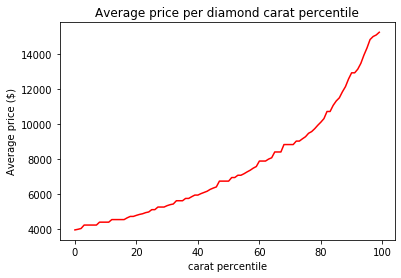

In [67]:
price_x_percentile = []
for x in range(100):
    price_x_percentile.append(df[df['carat'] > np.percentile(df['carat'], x)]['price'].mean())

plt.plot(price_x_percentile, color='red')
plt.xlabel("carat percentile")
plt.ylabel('Average price ($)')
plt.title('Average price per diamond carat percentile')
plt.show()

In [120]:
np.percentile(df['carat'], 97)

2.01

In [121]:
(coefs[coefs['feature'] == 'carat']['coefficient'] - num_col_mean['carat']) / num_col_stdev['carat']

0    8861.904876
Name: coefficient, dtype: float64